## steps invovled

1. read shape file and organize district, livlelihood and Karamoja region shape extent
2. Read the netcdf file and clip the netcdf into shape file boundaries for each region/district
3. Average the values collected from boundary clip operation
4. Organize the data into row for different months and columns for different region/district boundares

In [109]:
import glob
import geopandas as gp
import pandas as pd
import numpy as np

In [1]:


shpfiles=glob.glob('/home/data_folder/karamoja_shapefiles/*/*.shp')
shpfiles

['/home/data_folder/karamoja_shapefiles/Karamoja_9districts/Karamoja_9_districts.shp',
 '/home/data_folder/karamoja_shapefiles/Karamoja_boundary_dissolved/Karamoja_boundary_dissolved.shp',
 '/home/data_folder/karamoja_shapefiles/Karamoja_livelihood_zones/livelihood_zones_karamoja.shp',
 '/home/data_folder/karamoja_shapefiles/Karamoja_Subcounties/Karamoja_Subcounties.shp']

In [46]:


dist_shp=gp.read_file(shpfiles[0])
#dist_shp.plot()
#dist_shp.info()

kara_shp=gp.read_file(shpfiles[1])
#kara_shp.plot()

lh_shp=gp.read_file(shpfiles[2])
#lh_shp.plot()

sc_shp=gp.read_file(shpfiles[3])
#sc_shp.plot()


In [53]:
dist_shp1=dist_shp[['admin2Name','geometry']]
dist_shp1.columns=['admin_name','geometry']
lh_shp1=lh_shp[['livelihood','geometry']]
lh_shp1.columns=['admin_name','geometry']
kara_shp1=kara_shp[['geometry']]
kara_shp1['admin_name']='karamoja'
#kara_shp1.columns=['admin_name','geometry']

geo_db=pd.concat([dist_shp1,lh_shp1,kara_shp1])
geo_db1=geo_db.reset_index()
geo_db2=geo_db1[['admin_name','geometry']]
geo_db2['admin_name1']=geo_db2['admin_name'].str.lower()
admin_bound_list=geo_db2['admin_name1'].tolist()
admin_bound_list

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


['abim',
 'napak',
 'nabilatuk',
 'kotido',
 'moroto',
 'nakapiripirit',
 'kaabong',
 'karenga',
 'amudat',
 'nab_nak_napak',
 'abi_kar_kaboong',
 'mor_kot_amudat',
 'karamoja']

## Standardized_Precipitation_Index_SPI12

In [107]:

def region_shp_averager(single_row_shp,xds,var_str):
    #xds = rioxarray.open_rasterio(ncfile_path)
    clipped = xds.rio.clip(single_row_shp.geometry.values, single_row_shp.crs)
    year_xds=xds.indexes['time'].to_datetimeindex()
    year_str=str(year_xds[0].year)
    da=clipped.loc[dict(time=slice(year_str))]
    datetimeindex = da.indexes['time'].to_datetimeindex()
    da1=da[var_str]
    aa=da1.values
    array_index=np.arange(0,len(datetimeindex),1)
    cont_mean=[]
    for array_v in array_index:
        aa1=aa[array_v,:,:]
        aa2=aa1.ravel()
        aa3 = aa2[(aa2 >=-9000)]
        cont_mean.append(np.mean(aa3))
    return cont_mean,datetimeindex


ncfiles=glob.glob('/home/data_folder/icpac_data/data/IGAD_Standardized_Precipitation_Index_SPI12/CHIRPS/*.nc')


mdb_cont=[]
for ncfile_path in ncfiles:
    xds = rioxarray.open_rasterio(ncfile_path)
    var_str='spg12'
    db_cont=[]
    for ab_str in admin_bound_list:
        geo_db3=geo_db2[geo_db2['admin_name1']==ab_str]
        single_row_shp=ls1        
        cont_mean,datetimeindex=region_shp_averager(geo_db3,xds,var_str)
        db=pd.DataFrame()
        db[ab_str]=cont_mean
        #db['date']=datetimeindex  
        #print(db)
        #print(ab_str)
        db_cont.append(db)
        cont_mean=[]
        geo_db3=[]
    db1=pd.concat(db_cont,axis=1)
    db1.insert(loc=0, column='date', value=datetimeindex)
    datetimeindex=[]
    mdb_cont.append(db1)
        
mdb1=pd.concat(mdb_cont,axis=0)
mdb1.to_csv('/home/data_folder/IGAD_Standardized_Precipitation_Index_SPI12_CHRIPS.csv',index=False)


/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version th

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

In [111]:
var_ncfile='/home/data_folder/icpac_data/data/IGAD_Standardized_Precipitation_Index_SPI1/CHIRPS/spg01_m_igad_200001_200012_m.nc'
xds = rioxarray.open_rasterio(var_ncfile)
xds

<xarray.Dataset>
Dimensions:             (time: 12, x: 591, y: 698)
Coordinates:
  * time                (time) object 2000-01-01 00:00:00 ... 2000-12-01 00:0...
  * x                   (x) float64 21.88 21.93 21.98 ... 51.28 51.33 51.38
  * y                   (y) float64 -11.72 -11.67 -11.62 ... 23.02 23.08 23.12
    latitude_longitude  int64 0
Data variables:
    spg01               (time, y, x) float32 ...
Attributes: (12/28)
    lat#_FillValue:                                  nan
    latitude_longitude#crs_wkt:                      GEOGCS["WGS 84",DATUM["W...
    latitude_longitude#geographic_crs_name:          WGS 84
    latitude_longitude#GeoTransform:                 21.85 0.05 0.0 -11.75 0....
    latitude_longitude#grid_mapping_name:            latitude_longitude
    latitude_longitude#inverse_flattening:           298.257223563
    ...                                              ...
    spg01#grid_mapping:                              latitude_longitude
    spg01#units:                                     dimensionless
    spg01#_FillValue:                                -9999
    time#calendar:                                   proleptic_gregorian
    time#standard_name:                              time
    time#units:                                      days since 2000-01-01 00...

## Standardized_Precipitation_Index_SPI01

In [119]:
ncfiles=glob.glob('/home/data_folder/icpac_data/data/IGAD_Standardized_Precipitation_Index_SPI1/CHIRPS/*.nc')


mdb_cont=[]
for ncfile_path in ncfiles:
    xds = rioxarray.open_rasterio(ncfile_path)
    var_str='spg01'
    db_cont=[]
    for ab_str in admin_bound_list:
        geo_db3=geo_db2[geo_db2['admin_name1']==ab_str]
        single_row_shp=ls1        
        cont_mean,datetimeindex=region_shp_averager(geo_db3,xds,var_str)
        db=pd.DataFrame()
        db[ab_str]=cont_mean
        #db['date']=datetimeindex  
        #print(db)
        #print(ab_str)
        db_cont.append(db)
        cont_mean=[]
        geo_db3=[]
    db1=pd.concat(db_cont,axis=1)
    db1.insert(loc=0, column='date', value=datetimeindex)
    datetimeindex=[]
    mdb_cont.append(db1)
        
mdb1=pd.concat(mdb_cont,axis=0)
mdb1.to_csv('/home/data_folder/IGAD_Standardized_Precipitation_Index_SPI01_CHRIPS.csv',index=False)

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

## Standardized_Precipitation_Index_SPI03

In [118]:
ncfiles=glob.glob('/home/data_folder/icpac_data/data/IGAD_Standardized_Precipitation_Index_SPI3/CHIRPS/*.nc')


mdb_cont=[]
for ncfile_path in ncfiles:
    xds = rioxarray.open_rasterio(ncfile_path)
    var_str='spg03'
    db_cont=[]
    for ab_str in admin_bound_list:
        geo_db3=geo_db2[geo_db2['admin_name1']==ab_str]
        single_row_shp=ls1        
        cont_mean,datetimeindex=region_shp_averager(geo_db3,xds,var_str)
        db=pd.DataFrame()
        db[ab_str]=cont_mean
        #db['date']=datetimeindex  
        #print(db)
        #print(ab_str)
        db_cont.append(db)
        cont_mean=[]
        geo_db3=[]
    db1=pd.concat(db_cont,axis=1)
    db1.insert(loc=0, column='date', value=datetimeindex)
    datetimeindex=[]
    mdb_cont.append(db1)
        
mdb1=pd.concat(mdb_cont,axis=0)
mdb1.to_csv('/home/data_folder/IGAD_Standardized_Precipitation_Index_SPI03_CHRIPS.csv',index=False)

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

## Standardized_Precipitation_Index_SPI06

In [117]:
ncfiles=glob.glob('/home/data_folder/icpac_data/data/IGAD_Standardized_Precipitation_Index_SPI6/CHIRPS/*.nc')


mdb_cont=[]
for ncfile_path in ncfiles:
    xds = rioxarray.open_rasterio(ncfile_path)
    var_str='spg06'
    db_cont=[]
    for ab_str in admin_bound_list:
        geo_db3=geo_db2[geo_db2['admin_name1']==ab_str]
        single_row_shp=ls1        
        cont_mean,datetimeindex=region_shp_averager(geo_db3,xds,var_str)
        db=pd.DataFrame()
        db[ab_str]=cont_mean
        #db['date']=datetimeindex  
        #print(db)
        #print(ab_str)
        db_cont.append(db)
        cont_mean=[]
        geo_db3=[]
    db1=pd.concat(db_cont,axis=1)
    db1.insert(loc=0, column='date', value=datetimeindex)
    datetimeindex=[]
    mdb_cont.append(db1)
        
mdb1=pd.concat(mdb_cont,axis=0)
mdb1.to_csv('/home/data_folder/IGAD_Standardized_Precipitation_Index_SPI06_CHRIPS.csv',index=False)

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dty

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

## Standardized_Precipitation_Index_SPI09

In [116]:
ncfiles=glob.glob('/home/data_folder/icpac_data/data/IGAD_Standardized_Precipitation_Index_SPI9/CHIRPS/*.nc')


mdb_cont=[]
for ncfile_path in ncfiles:
    xds = rioxarray.open_rasterio(ncfile_path)
    var_str='spg09'
    db_cont=[]
    for ab_str in admin_bound_list:
        geo_db3=geo_db2[geo_db2['admin_name1']==ab_str]
        single_row_shp=ls1        
        cont_mean,datetimeindex=region_shp_averager(geo_db3,xds,var_str)
        db=pd.DataFrame()
        db[ab_str]=cont_mean
        #db['date']=datetimeindex  
        #print(db)
        #print(ab_str)
        db_cont.append(db)
        cont_mean=[]
        geo_db3=[]
    db1=pd.concat(db_cont,axis=1)
    db1.insert(loc=0, column='date', value=datetimeindex)
    datetimeindex=[]
    mdb_cont.append(db1)
        
mdb1=pd.concat(mdb_cont,axis=0)
mdb1.to_csv('/home/data_folder/IGAD_Standardized_Precipitation_Index_SPI09_CHRIPS.csv',index=False)

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dty

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

## Standardized_Precipitation_Index_SPI24

In [115]:
ncfiles=glob.glob('/home/data_folder/icpac_data/data/IGAD_Standardized_Precipitation_Index_SPI24/CHIRPS/*.nc')


mdb_cont=[]
for ncfile_path in ncfiles:
    xds = rioxarray.open_rasterio(ncfile_path)
    var_str='spg24'
    db_cont=[]
    for ab_str in admin_bound_list:
        geo_db3=geo_db2[geo_db2['admin_name1']==ab_str]
        single_row_shp=ls1        
        cont_mean,datetimeindex=region_shp_averager(geo_db3,xds,var_str)
        db=pd.DataFrame()
        db[ab_str]=cont_mean
        #db['date']=datetimeindex  
        #print(db)
        #print(ab_str)
        db_cont.append(db)
        cont_mean=[]
        geo_db3=[]
    db1=pd.concat(db_cont,axis=1)
    db1.insert(loc=0, column='date', value=datetimeindex)
    datetimeindex=[]
    mdb_cont.append(db1)
        
mdb1=pd.concat(mdb_cont,axis=0)
mdb1.to_csv('/home/data_folder/IGAD_Standardized_Precipitation_Index_SPI24_CHRIPS.csv',index=False)

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dty

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

## Standardized_Precipitation_Index_SPI48

In [114]:
ncfiles=glob.glob('/home/data_folder/icpac_data/data/IGAD_Standardized_Precipitation_Index_SPI48/CHIRPS/*.nc')


mdb_cont=[]
for ncfile_path in ncfiles:
    xds = rioxarray.open_rasterio(ncfile_path)
    var_str='spg48'
    db_cont=[]
    for ab_str in admin_bound_list:
        geo_db3=geo_db2[geo_db2['admin_name1']==ab_str]
        single_row_shp=ls1        
        cont_mean,datetimeindex=region_shp_averager(geo_db3,xds,var_str)
        db=pd.DataFrame()
        db[ab_str]=cont_mean
        #db['date']=datetimeindex  
        #print(db)
        #print(ab_str)
        db_cont.append(db)
        cont_mean=[]
        geo_db3=[]
    db1=pd.concat(db_cont,axis=1)
    db1.insert(loc=0, column='date', value=datetimeindex)
    datetimeindex=[]
    mdb_cont.append(db1)
        
mdb1=pd.concat(mdb_cont,axis=0)
mdb1.to_csv('/home/data_folder/IGAD_Standardized_Precipitation_Index_SPI48_CHRIPS.csv',index=False)

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dty

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


In [112]:
var_ncfile='/home/data_folder/icpac_data/data/IGAD_Combined_Drought_Indicator/CHIRPS/cdinx_m_igad_20010101_20011221_t.nc'
xds = rioxarray.open_rasterio(var_ncfile)
xds

<xarray.Dataset>
Dimensions:             (time: 36, x: 296, y: 348)
Coordinates:
  * time                (time) object 2001-01-01 00:00:00 ... 2001-12-21 00:0...
  * x                   (x) float64 21.85 21.95 22.05 ... 51.15 51.25 51.35
  * y                   (y) float64 -11.65 -11.55 -11.45 ... 22.85 22.95 23.05
    latitude_longitude  int64 0
Data variables:
    cdinx               (time, y, x) float32 ...
Attributes: (12/28)
    cdinx#coordinates:                               latitude_longitude
    cdinx#grid_mapping:                              latitude_longitude
    cdinx#units:                                     dimensionless
    cdinx#_FillValue:                                -9999
    lat#_FillValue:                                  nan
    latitude_longitude#crs_wkt:                      GEOGCS["WGS 84",DATUM["W...
    ...                                              ...
    NETCDF_DIM_EXTRA:                                {time}
    NETCDF_DIM_time_DEF:                             [36. 10.]
    NETCDF_DIM_time_VALUES:                          [  0.  10.  20.  31.  41...
    time#calendar:                                   proleptic_gregorian
    time#standard_name:                              time
    time#units:                                      days since 2001-01-01

## Combined_Drought_Indicator

In [113]:
ncfiles=glob.glob('/home/data_folder/icpac_data/data/IGAD_Combined_Drought_Indicator/CHIRPS/*.nc')


mdb_cont=[]
for ncfile_path in ncfiles:
    xds = rioxarray.open_rasterio(ncfile_path)
    var_str='cdinx'
    db_cont=[]
    for ab_str in admin_bound_list:
        geo_db3=geo_db2[geo_db2['admin_name1']==ab_str]
        single_row_shp=ls1        
        cont_mean,datetimeindex=region_shp_averager(geo_db3,xds,var_str)
        db=pd.DataFrame()
        db[ab_str]=cont_mean
        #db['date']=datetimeindex  
        #print(db)
        #print(ab_str)
        db_cont.append(db)
        cont_mean=[]
        geo_db3=[]
    db1=pd.concat(db_cont,axis=1)
    db1.insert(loc=0, column='date', value=datetimeindex)
    datetimeindex=[]
    mdb_cont.append(db1)
        
mdb1=pd.concat(mdb_cont,axis=0)
mdb1.to_csv('/home/data_folder/IGAD_Combined_Drought_Indicator_CHRIPS.csv',index=False)

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/

## dev and test routines 

In [11]:
lh_shp['admin4Name'].tolist()

ls1=lh_shp[lh_shp['admin4Name']=='Lolachat']
ls1.geometry.values

<GeometryArray>
Length: 1, dtype: geometry

In [4]:

ncfiles=glob.glob('/home/data_folder/icpac_data/data/IGAD_Standardized_Precipitation_Index_SPI12/CHIRPS/*.nc')

ncfiles

['/home/data_folder/icpac_data/data/IGAD_Standardized_Precipitation_Index_SPI12/CHIRPS/spg12_m_igad_200001_200012_m.nc',
 '/home/data_folder/icpac_data/data/IGAD_Standardized_Precipitation_Index_SPI12/CHIRPS/spg12_m_igad_200101_200112_m.nc',
 '/home/data_folder/icpac_data/data/IGAD_Standardized_Precipitation_Index_SPI12/CHIRPS/spg12_m_igad_200201_200212_m.nc',
 '/home/data_folder/icpac_data/data/IGAD_Standardized_Precipitation_Index_SPI12/CHIRPS/spg12_m_igad_200301_200312_m.nc',
 '/home/data_folder/icpac_data/data/IGAD_Standardized_Precipitation_Index_SPI12/CHIRPS/spg12_m_igad_200401_200412_m.nc',
 '/home/data_folder/icpac_data/data/IGAD_Standardized_Precipitation_Index_SPI12/CHIRPS/spg12_m_igad_200501_200512_m.nc',
 '/home/data_folder/icpac_data/data/IGAD_Standardized_Precipitation_Index_SPI12/CHIRPS/spg12_m_igad_200601_200612_m.nc',
 '/home/data_folder/icpac_data/data/IGAD_Standardized_Precipitation_Index_SPI12/CHIRPS/spg12_m_igad_200701_200712_m.nc',
 '/home/data_folder/icpac_data/d

In [106]:
import rioxarray
import geopandas as gp

#geodf = gp.read_file()
xds = rioxarray.open_rasterio(ncfiles[0])
aa=xds.indexes['time']
#aa.to_datetimeindex()
aa.to_datetimeindex()
#clipped = xds.rio.clip(kara_shp.geometry.values, kara_shp.crs)

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01', '2000-11-01', '2000-12-01'],
              dtype='datetime64[ns]', freq=None)

In [79]:
#xds.time

aa=xds.indexes['time'].to_datetimeindex()
aa[0].year

2000

In [18]:
da=clipped.sel(time=slice('2009-01-01'))
#da

da=clipped.loc[dict(time=slice('2000'))]

#clipped[0].plot.scatter()
#clipped
#da.plot((column="elevation_max", legend=True)
da

<xarray.Dataset>
Dimensions:             (time: 12, x: 30, y: 56)
Coordinates:
  * time                (time) object 2000-01-01 00:00:00 ... 2000-12-01 00:0...
  * x                   (x) float64 33.52 33.58 33.62 ... 34.88 34.92 34.98
  * y                   (y) float64 1.425 1.475 1.525 ... 4.075 4.125 4.175
    spatial_ref         int64 0
    latitude_longitude  int64 0
Data variables:
    spg12               (time, y, x) float32 -9.999e+03 ... -9.999e+03
Attributes: (12/28)
    lat#_FillValue:                                  nan
    latitude_longitude#crs_wkt:                      GEOGCS["WGS 84",DATUM["W...
    latitude_longitude#geographic_crs_name:          WGS 84
    latitude_longitude#GeoTransform:                 21.85 0.05 0.0 -11.75 0....
    latitude_longitude#grid_mapping_name:            latitude_longitude
    latitude_longitude#inverse_flattening:           298.257223563
    ...                                              ...
    spg12#grid_mapping:                              latitude_longitude
    spg12#units:                                     dimensionless
    spg12#_FillValue:                                -9999
    time#calendar:                                   proleptic_gregorian
    time#standard_name:                              time
    time#units:                                      days since 2000-01-01 00...

In [86]:
da1=da['spg12']
aa=da1.values


In [90]:
aa1=aa[0,:,:]
aa1.stack()
#aa2=aa1.ravel()
#len(aa2)

AttributeError: 'numpy.ndarray' object has no attribute 'stack'

In [21]:
aa3 = aa2[(aa2 >=-9000)]

len(aa3)

899

In [22]:
import numpy as np
np.mean(aa3)

-0.6068654

In [23]:
import pandas as pd
import datetime
import cftime
db=pd.DataFrame()

#db['time']=da.time.values
#db['time1']=db['time'].apply(pd.to_datetime)
#db.info()

aa=da.time.values

#datetime.datetime(aa[0])


#t = cftime.num2date(aa[0])

#cftime.to_tuple(aa[0])

import xarray as xr
da1=xr.decode_cf(da, decode_times=True,use_cftime=False)

db['time']=da1.time.values
#db['time1']=db['time'].apply(pd.to_datetime)
#db.info()

aa=da1.time.values
aa

#https://stackoverflow.com/a/55787899
datetimeindex = da.indexes['time'].to_datetimeindex()

datetimeindex

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01', '2000-11-01', '2000-12-01'],
              dtype='datetime64[ns]', freq=None)

In [32]:
da

<xarray.Dataset>
Dimensions:             (time: 12, x: 30, y: 56)
Coordinates:
  * time                (time) object 2000-01-01 00:00:00 ... 2000-12-01 00:0...
  * x                   (x) float64 33.52 33.58 33.62 ... 34.88 34.92 34.98
  * y                   (y) float64 1.425 1.475 1.525 ... 4.075 4.125 4.175
    spatial_ref         int64 0
    latitude_longitude  int64 0
Data variables:
    spg12               (time, y, x) float32 -9.999e+03 ... -9.999e+03
Attributes: (12/28)
    lat#_FillValue:                                  nan
    latitude_longitude#crs_wkt:                      GEOGCS["WGS 84",DATUM["W...
    latitude_longitude#geographic_crs_name:          WGS 84
    latitude_longitude#GeoTransform:                 21.85 0.05 0.0 -11.75 0....
    latitude_longitude#grid_mapping_name:            latitude_longitude
    latitude_longitude#inverse_flattening:           298.257223563
    ...                                              ...
    spg12#grid_mapping:                              latitude_longitude
    spg12#units:                                     dimensionless
    spg12#_FillValue:                                -9999
    time#calendar:                                   proleptic_gregorian
    time#standard_name:                              time
    time#units:                                      days since 2000-01-01 00...

In [32]:
aa=da1.values

da1=da['spg12']
aa=da1.values

array_index=np.arange(0,len(datetimeindex),1)
cont_mean=[]
for array_v in array_index:
    aa1=aa[array_v,:,:]
    aa2=aa1.ravel()
    aa3 = aa2[(aa2 >=-9000)]
    cont_mean.append(np.mean(aa3))

In [35]:
aa.shape

aa1=aa[0,:,:]

In [33]:
array_index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [21]:
 print(cftime.__version__)

1.6.1


In [37]:
import numpy as np
import pandas as pd

def region_shp_averager(single_row_shp,ncfile_path,year_str,var_str):
    xds = rioxarray.open_rasterio(ncfile_path)
    clipped = xds.rio.clip(single_row_shp.geometry.values, single_row_shp.crs)
    da=clipped.loc[dict(time=slice(year_str))]
    datetimeindex = da.indexes['time'].to_datetimeindex()
    da1=da[var_str]
    aa=da1.values
    array_index=np.arange(0,len(datetimeindex),1)
    cont_mean=[]
    for array_v in array_index:
        aa1=aa[array_v,:,:]
        aa2=aa1.ravel()
        aa3 = aa2[(aa2 >=-9000)]
        cont_mean.append(np.mean(aa3))
    return cont_mean,datetimeindex



single_row_shp=ls1
ncfile_path='/home/data_folder/icpac_data/data/IGAD_Standardized_Precipitation_Index_SPI12/CHIRPS/spg12_m_igad_200001_200012_m.nc'
year_str='2001'
var_str='spg12'

cont_mean,datetimeindex=region_shp_averager(single_row_shp,ncfile_path,year_str,var_str)


db=pd.DataFrame()

db[var_str]=cont_mean
db['date']=datetimeindex        
db  

/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


,spg12,date
0,-0.552276,2000-01-01
1,-0.569986,2000-02-01
2,-1.277927,2000-03-01
3,-1.484420,2000-04-01
4,-1.170105,2000-05-01
5,-0.801028,2000-06-01
6,-0.705353,2000-07-01
7,-0.604056,2000-08-01
8,-0.332266,2000-09-01
9,-0.064108,2000-10-01


## WRSI 

In [1]:
%load_ext dotenv
%dotenv

In [2]:
import os
folder_path = os.getenv('work')

In [4]:
import glob
import geopandas as gp
import pandas as pd
import numpy as np
import xarray as xr
import cf_xarray as cfxr




shpfiles=glob.glob(f'{folder_path}UGA/karamoja_admin_shapefiles/*/*.shp')
print(shpfiles)
dist_shp=gp.read_file(shpfiles[1])
#dist_shp.plot()
#dist_shp.info()

kara_shp=gp.read_file(shpfiles[2])
#kara_shp.plot()

lh_shp=gp.read_file(shpfiles[0])
#lh_shp.plot()

sc_shp=gp.read_file(shpfiles[3])
#sc_shp.plot()




dist_shp1=dist_shp[['admin2Name','geometry']]
dist_shp1.columns=['admin_name','geometry']
lh_shp1=lh_shp[['livelihood','geometry']]
lh_shp1.columns=['admin_name','geometry']
kara_shp1=kara_shp[['geometry']]
kara_shp1['admin_name']='karamoja'
#kara_shp1.columns=['admin_name','geometry']

geo_db=pd.concat([dist_shp1,lh_shp1,kara_shp1])
geo_db1=geo_db.reset_index()
geo_db2=geo_db1[['admin_name','geometry']]
geo_db2['admin_name1']=geo_db2['admin_name'].str.lower()
admin_bound_list=geo_db2['admin_name1'].tolist()
admin_bound_list



def region_shp_averager(single_row_shp,xds,var_str):
    #xds = rioxarray.open_rasterio(ncfile_path)
    clipped = xds.rio.clip(single_row_shp.geometry.values, single_row_shp.crs)
    year_xds=xds.indexes['time'].to_datetimeindex()
    year_str=str(year_xds[0].year)
    da=clipped.loc[dict(time=slice(year_str))]
    datetimeindex = da.indexes['time'].to_datetimeindex()
    da1=da[var_str]
    aa=da1.values
    array_index=np.arange(0,len(datetimeindex),1)
    cont_mean=[]
    for array_v in array_index:
        aa1=aa[array_v,:,:]
        aa2=aa1.ravel()
        aa3 = aa2[(aa2 >=-9000)]
        cont_mean.append(np.mean(aa3))
    return cont_mean,datetimeindex

wrsi_data_path=f'{folder_path}tamsat/for_training/beta_hist.nc'


db=xr.open_dataset(wrsi_data_path)
#db.beta_hist.cf.isel(time=1).cf.plot(x="longitude", y="latitude")
db1=db.cf.resample(time="MS").mean()

#xds = rioxarray.open_rasterio(wrsi_data_path)
db1.rio.write_crs(4326, inplace=True)
var_str='beta_hist'
db_cont=[]
for ab_str in admin_bound_list[12:13]:
    geo_db3=geo_db2[geo_db2['admin_name1']==ab_str]    
    #clipped = db1.rio.clip(geo_db3.geometry.values, geo_db3.crs)
    #fb1=region_shp_averager(geo_db3,xds,var_str,date_str_list)
    
#db1.rio.write_crs(4326, inplace=True)
clipped = db1.rio.clip(geo_db3.geometry.values, geo_db3.crs)
#year_xds=db.indexes['time']
#year_str=str(year_xds[0].year)
datetimeindex = clipped.indexes['time']
da1=clipped[var_str]
aa=da1.values
array_index=np.arange(0,len(datetimeindex),1)
cont_mean=[]
for array_v in array_index:
    aa1=aa[array_v,:,:]
    aa2=aa1.ravel()
    aa3 = aa2[(aa2 >=-9000)]
    cont_mean.append(np.mean(aa3))
fb=pd.DataFrame()
fb['karamoja']=cont_mean
fb['date']=datetimeindex  
#db_cont.append(fb)

fb   
#fb1=pd.concat(cont_mean,axis=0) 

#db1=pd.concat(db_cont,axis=1)
#db1.insert(loc=0, column='date', value=datetimeindex)
#datetimeindex=[]
# mdb_cont.append(db1)
        
# mdb1=pd.concat(mdb_cont,axis=0)
fb1=fb[['date','karamoja']]
fb1.to_csv(f'{folder_path}tamsat/TAMSAT_custom_WRSI.csv',index=False)

['/home/bulbul/Documents/07-2022/impact_weather_icpac/lab/UGA/karamoja_admin_shapefiles/Karamoja_livelihood_zones/livelihood_zones_karamoja.shp', '/home/bulbul/Documents/07-2022/impact_weather_icpac/lab/UGA/karamoja_admin_shapefiles/Karamoja_9_districts/Karamoja_9_districts.shp', '/home/bulbul/Documents/07-2022/impact_weather_icpac/lab/UGA/karamoja_admin_shapefiles/Karamoja_boundary_dissolved/Karamoja_boundary_dissolved.shp', '/home/bulbul/Documents/07-2022/impact_weather_icpac/lab/UGA/karamoja_admin_shapefiles/Karamoja_Subcounties/Karamoja_Subcounties.shp']


In [91]:
import xarray as xr

wrsi_data_path=f'{folder_path}tamsat/for_training/beta_hist.nc'

db=xr.open_dataset(wrsi_data_path)

db1=db['time'][0]
#db1['beta_hist']

db1=db.sel(time='2003-01-01T00:00:00.000000000')
db2=db1['beta_hist']
#db2.plot()

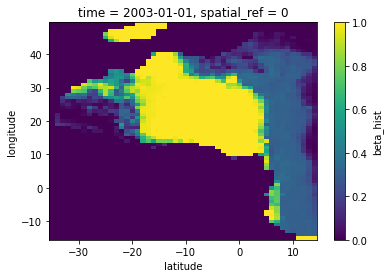

In [7]:
db.rio.write_crs(4326, inplace=True)
db1=db.sel(time='2003-01-01T00:00:00.000000000')
db2=db1['beta_hist']
db2.plot()

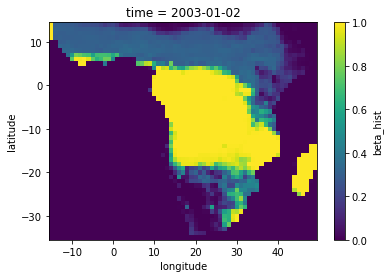

In [92]:
import cf_xarray as cfxr

db.beta_hist.cf.isel(time=1).cf.plot(x="longitude", y="latitude")

In [93]:
db1=db.cf.resample(time="MS").mean()
db1

<xarray.Dataset>
Dimensions:    (time: 180, longitude: 65, latitude: 50)
Coordinates:
  * time       (time) datetime64[ns] 2003-01-01 2003-02-01 ... 2017-12-01
  * longitude  (longitude) int64 -15 -14 -13 -12 -11 -10 ... 44 45 46 47 48 49
  * latitude   (latitude) int64 -35 -34 -33 -32 -31 -30 -29 ... 9 10 11 12 13 14
Data variables:
    beta_hist  (time, longitude, latitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [94]:
import pandas as pd
date_str_list=pd.date_range('2003-01-01','2018-01-01', freq='Y').strftime("%Y").tolist()
date_str_list

['2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017']

In [107]:
import rioxarray


def region_shp_averager(single_row_shp,xds,var_str,date_str_list):
    #xds = rioxarray.open_rasterio(ncfile_path)
    #clipped = xds.rio.clip(single_row_shp.geometry.values, single_row_shp.crs)
    db1.rio.write_crs(4326, inplace=True)
    clipped = db1.rio.clip(geo_db3.geometry.values, geo_db3.crs)
    year_xds=db.indexes['time']
    #year_str=str(year_xds[0].year)
    db_cont=[]
    for year_str in date_str_list:
        da=clipped.loc[dict(time=slice(year_str))]
        datetimeindex = da.indexes['time']
        da1=da[var_str]
        aa=da1.values
        array_index=np.arange(0,len(datetimeindex),1)
        cont_mean=[]
        for array_v in array_index:
            aa1=aa[array_v,:,:]
            aa2=aa1.ravel()
            aa3 = aa2[(aa2 >=-9000)]
            cont_mean.append(np.mean(aa3))
        fb=pd.DataFrame()
        fb['karamoja']=cont_mean
        fb['date']=datetimeindex  
        db_cont.append(fb)
    fb1=pd.concat(cont_mean,axis=0)    
    return fb1







In [72]:
geo_db3=geo_db2[geo_db2['admin_name1']==admin_bound_list[12]]   
single_row_shp=geo_db3
db1.rio.write_crs(4326, inplace=True)
print(single_row_shp)
clipped = db1.rio.clip(single_row_shp.geometry.values, single_row_shp.crs)


   admin_name                                           geometry admin_name1
12   karamoja  POLYGON ((33.84819 2.34390, 33.84817 2.34381, ...    karamoja


In [68]:
geo_db2

,admin_name,geometry,admin_name1
0,Abim,"POLYGON ((33.88095 2.67043, 33.91618 2.64811, ...",abim
1,Napak,"POLYGON ((34.57184 2.44468, 34.57196 2.44472, ...",napak
2,Nabilatuk,"POLYGON ((34.73150 2.03101, 34.73134 2.02951, ...",nabilatuk
3,Kotido,"POLYGON ((34.27412 2.84565, 34.27191 2.83537, ...",kotido
4,Moroto,"POLYGON ((34.93350 2.28239, 34.93227 2.28221, ...",moroto
5,Nakapiripirit,"POLYGON ((34.63113 1.57692, 34.63087 1.57694, ...",nakapiripirit
6,Kaabong,"POLYGON ((34.15669 3.21610, 34.15649 3.21612, ...",kaabong
7,Karenga,"POLYGON ((33.81495 3.51046, 33.81428 3.51023, ...",karenga
8,Amudat,"POLYGON ((34.99380 1.67981, 34.99324 1.67398, ...",amudat
9,Nab_Nak_Napak,"POLYGON ((34.22907 1.63980, 34.22907 1.63980, ...",nab_nak_napak


In [73]:
clipped

<xarray.Dataset>
Dimensions:      (longitude: 1, latitude: 2, time: 180)
Coordinates:
  * longitude    (longitude) int64 34
  * latitude     (latitude) int64 3 4
  * time         (time) datetime64[ns] 2003-01-01 2003-02-01 ... 2017-12-01
    spatial_ref  int64 0
Data variables:
    beta_hist    (time, longitude, latitude) float64 0.352 0.3504 ... 0.3407

In [74]:
db

<xarray.Dataset>
Dimensions:      (longitude: 65, latitude: 50, time: 5478)
Coordinates:
  * longitude    (longitude) int64 -15 -14 -13 -12 -11 -10 ... 44 45 46 47 48 49
  * latitude     (latitude) int64 -35 -34 -33 -32 -31 -30 ... 9 10 11 12 13 14
  * time         (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2017-12-30
    spatial_ref  int64 0
Data variables:
    beta_hist    (longitude, latitude, time) float64 ...